# Import Required Libraries

In [1]:
!pip install --upgrade scikit-learn --quiet

In [2]:
!pip install imodels --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.0/243.0 kB 9.3 MB/s eta 0:00:00


In [3]:
# Make a directory named '.kaggle'
!mkdir -p ~/.kaggle

# Move kaggle.json into this directory
!mv kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download dataset for regression
!kaggle datasets download -d mikhail1681/walmart-sales

# Download dataset for classification
!kaggle datasets download -d hb20007/gender-classification

Dataset URL: https://www.kaggle.com/datasets/mikhail1681/walmart-sales
License(s): other
  0% 0.00/122k [00:00<?, ?B/s]
100% 122k/122k [00:00<00:00, 30.8MB/s]
Dataset URL: https://www.kaggle.com/datasets/hb20007/gender-classification
License(s): CC-BY-SA-4.0
  0% 0.00/666 [00:00<?, ?B/s]
100% 666/666 [00:00<00:00, 1.27MB/s]


In [5]:
# Unzip the datasets
!unzip -q walmart-sales.zip
!unzip -q gender-classification.zip

# Datasets Chosen

### Dataset for Regression

1. Walmart Sales: https://www.kaggle.com/datasets/mikhail1681/walmart-sales </br>

The data contains the following columns:

Store: Store number </br>
Date: Sales week start date </br>
Weekly_Sales: Sales </br>
Holiday_Flag: Mark on the presence or absence of a holiday </br>
Temperature: Air temperature in the region </br>
Fuel_Price: Fuel cost in the region </br>
CPI: Consumer price index </br>
Unemployment: Unemployment rate </br>

### Dataset for Classification
2. Gender Classification: https://www.kaggle.com/datasets/hb20007/gender-classification

This small dataset is designed to provide an idea about whether a person's gender can be predicted with an accuracy significantly above 50% based on their personal preferences.

Despite the decrease in the influence of gender on peoples personal preferences, can a decent gender classifier be built given a dataset with peoples personal preferences?

# Import Required Libraries

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import imodels
from imodels import BoostedRulesClassifier, RuleFitRegressor, GreedyRuleListClassifier

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Read Datasets

In [26]:
df_reg = pd.read_csv('Walmart_Sales.csv')
df_reg = df_reg.drop(columns=['Date'], axis=1)
df_reg.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [27]:
df_clas = pd.read_csv('Transformed Data Set - Sheet1.csv')
df_clas.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


# Split Data into Training and Testing

In [28]:
X_reg = df_reg.drop(columns=['Weekly_Sales'])
y_reg = df_reg['Weekly_Sales']

X_clas = df_clas.drop(columns=['Gender'])
y_clas = df_clas['Gender']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_clas)

# One hot Encode gender_classification dataframe features
y_clas = df_clas['Gender']
X_clas = df_clas.drop('Gender', axis=1)
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X_clas)

In [63]:
print(label_encoder.classes_)
# 0 is female and 1 is male

['F' 'M']


In [29]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [11]:
def viz_classification_preds(probs, y_test):

    plt.subplot(121)
    plt.hist(probs[:, 1][y_test == 0], label='Class 0')
    plt.hist(probs[:, 1][y_test == 1], label='Class 1', alpha=0.8)
    plt.ylabel('Count')
    plt.xlabel('Predicted probability of class 1')
    plt.legend()

    plt.subplot(122)
    preds = np.argmax(probs, axis=1)
    plt.title('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(fpr, tpr)
    plt.tight_layout()
    plt.show()

## Algorithm 1: Boosted Rules Classifier

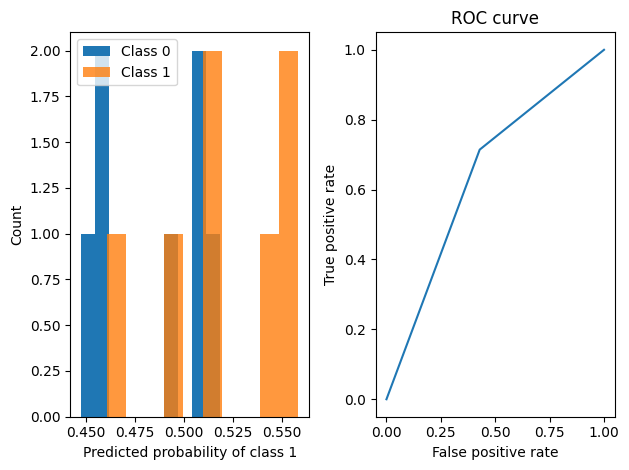

BoostedRulesClassifier(n_estimators=10)

In [12]:
brc = BoostedRulesClassifier(n_estimators=10)
brc.fit(X_train_clas, y_train_clas, feature_names=encoder.get_feature_names_out(X_clas.columns))

probs = brc.predict_proba(X_test_clas)
viz_classification_preds(probs, y_test_clas)

brc

## Graph Interpretation

The classifier can predict probabilities for Class 1 but struggles with clear separation between the two classes.

The ROC curve indicates that the model does a decent/moderate job at distinguishing between the two, though it is not perfect.

## Visual Explanation

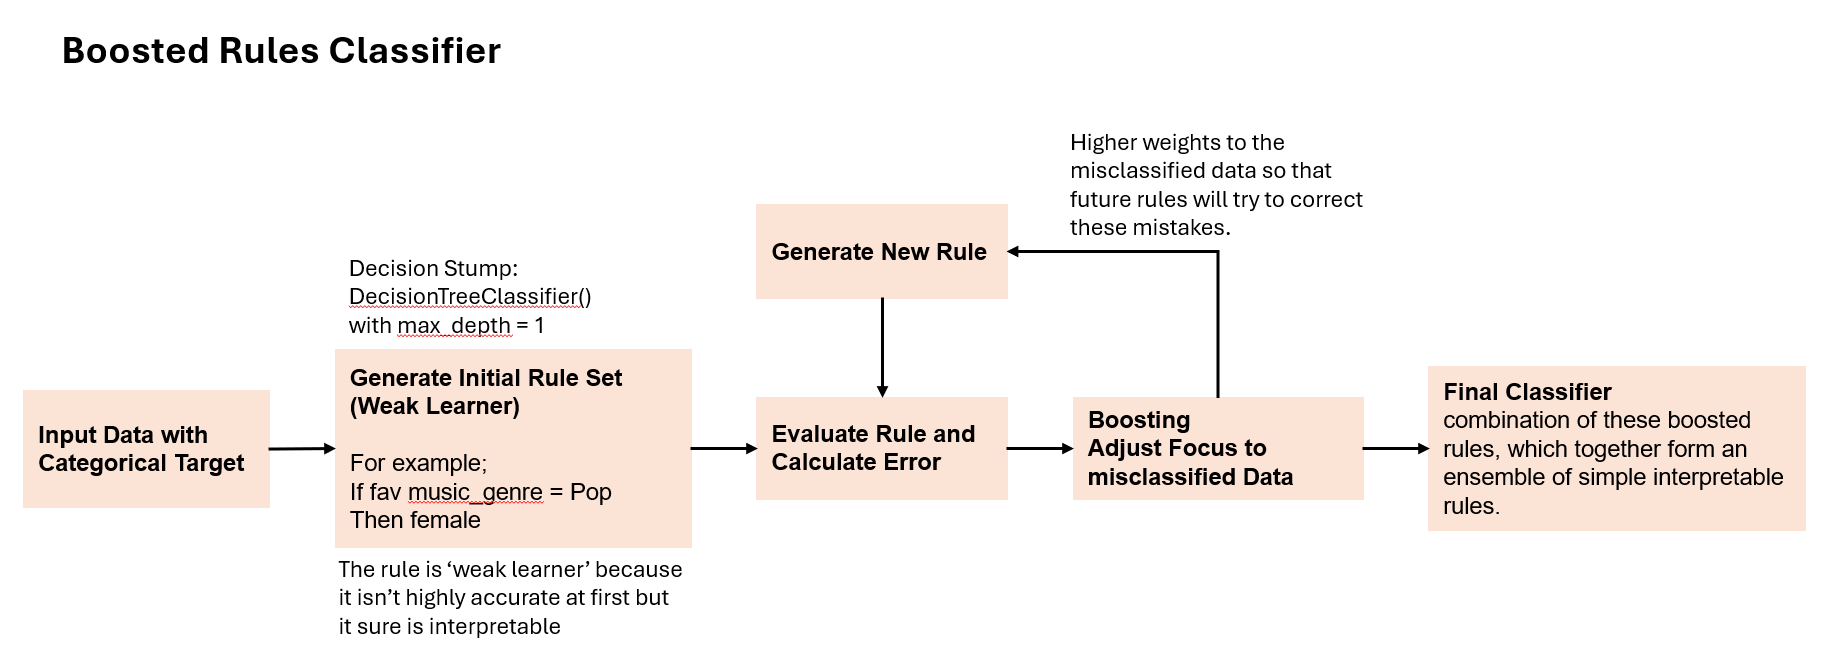

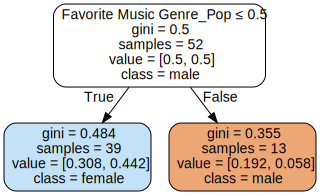

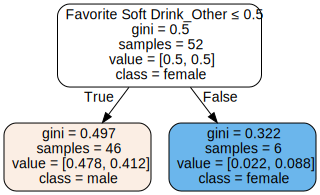

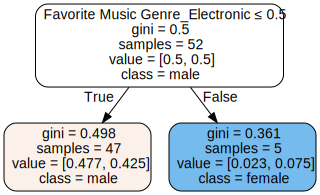

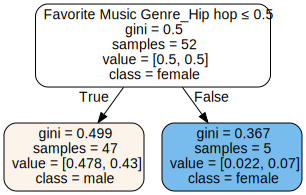

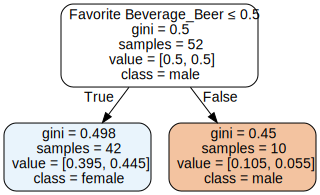

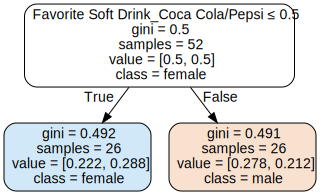

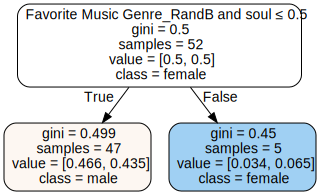

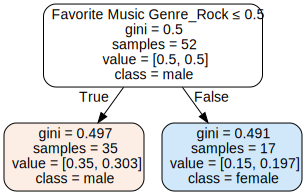

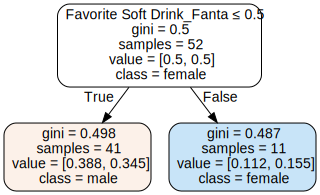

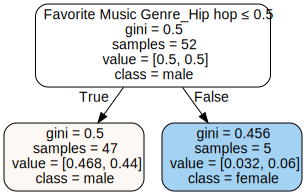

In [ ]:
# Visualizing the 10 Decision Stumps

def sanitize_feature_names(names):
    return [name.replace('&', 'and').replace('<', 'lt').replace('>', 'gt') for name in names]

sanitized_feature_names = sanitize_feature_names(encoder.get_feature_names_out(X_clas.columns))

for i, tree in enumerate(brc.estimators_):
    dot_data = export_graphviz(tree, out_file=None,
                               feature_names=sanitized_feature_names,
                               class_names=['male', 'female'],
                               filled=True, rounded=True,
                               special_characters=True)
    graph = Source(dot_data)
    # graph.render(f"boosted_rules_tree_{i}")
    display(graph)


## Interpretation of the above tree

There are a total of 10 Desicion Stumps.

1. The first stump is the condition based `Favorite Music Genre_Pop ≤ 0.5`.  Less than 0.5 is basically 0 i.e., does not enjoy pop music

2. Gini Index: Each node displays a Gini impurity score. A Gini index of 0 indicates perfect purity while a score of 0.5 indicates maximum impurity.

3. The first stump under condition `Favorite Music Genre_Pop ≤ 0.5` predicts `class = male`. So if a participant enjoys pop music, the model tends to classifies them as male.

4. Similarly the second stump under condition `Favorite Soft Drink_Other ≤ 0` predicts `class = female`. So if the participants favorite soft drink is not one of the mentioned ones in the dataset, it is likely female.

## Algorithm 2: Greedy Rule List Classifier

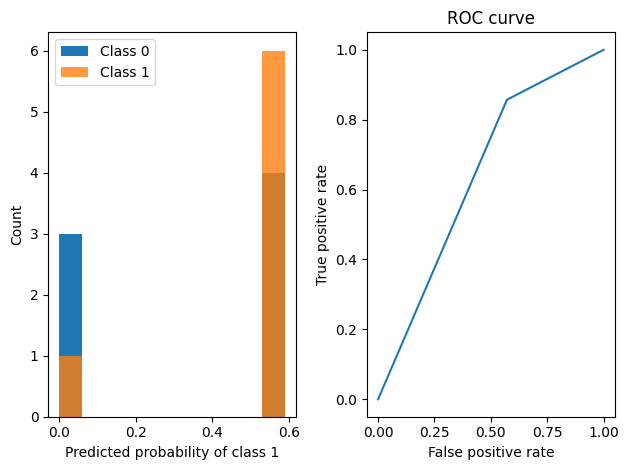

GreedyRuleListClassifier()

In [61]:
m = GreedyRuleListClassifier()
m.fit(X_train_clas, y=y_train_clas, feature_names=encoder.get_feature_names_out(X_clas.columns))  # stores into m.rules_
probs = m.predict_proba(X_test_clas)

viz_classification_preds(probs, y_test_clas)

m

## Interpreting the above graphs

The model predicts probabilities near 0 for many Class 0 examples which is good. There is some overlap with Class 1 so there are a few misclassifications happening. The relatively high confidence in Class 1 (about 0.6) for several cases seems accurate as most Class 1 i.e., orange bars are in this range.

## Interpreting the GreedyRuleList Classifier Output
Context:
We have encoded
female = 0
male = 1

Risk explains how likely the model thinks a person is male (class 1) at each stage of the rules.
A higher percentage means the model is more confident they are male. It also tells us how many samples the particular risk amount has been calculated on

## Visual Explanation

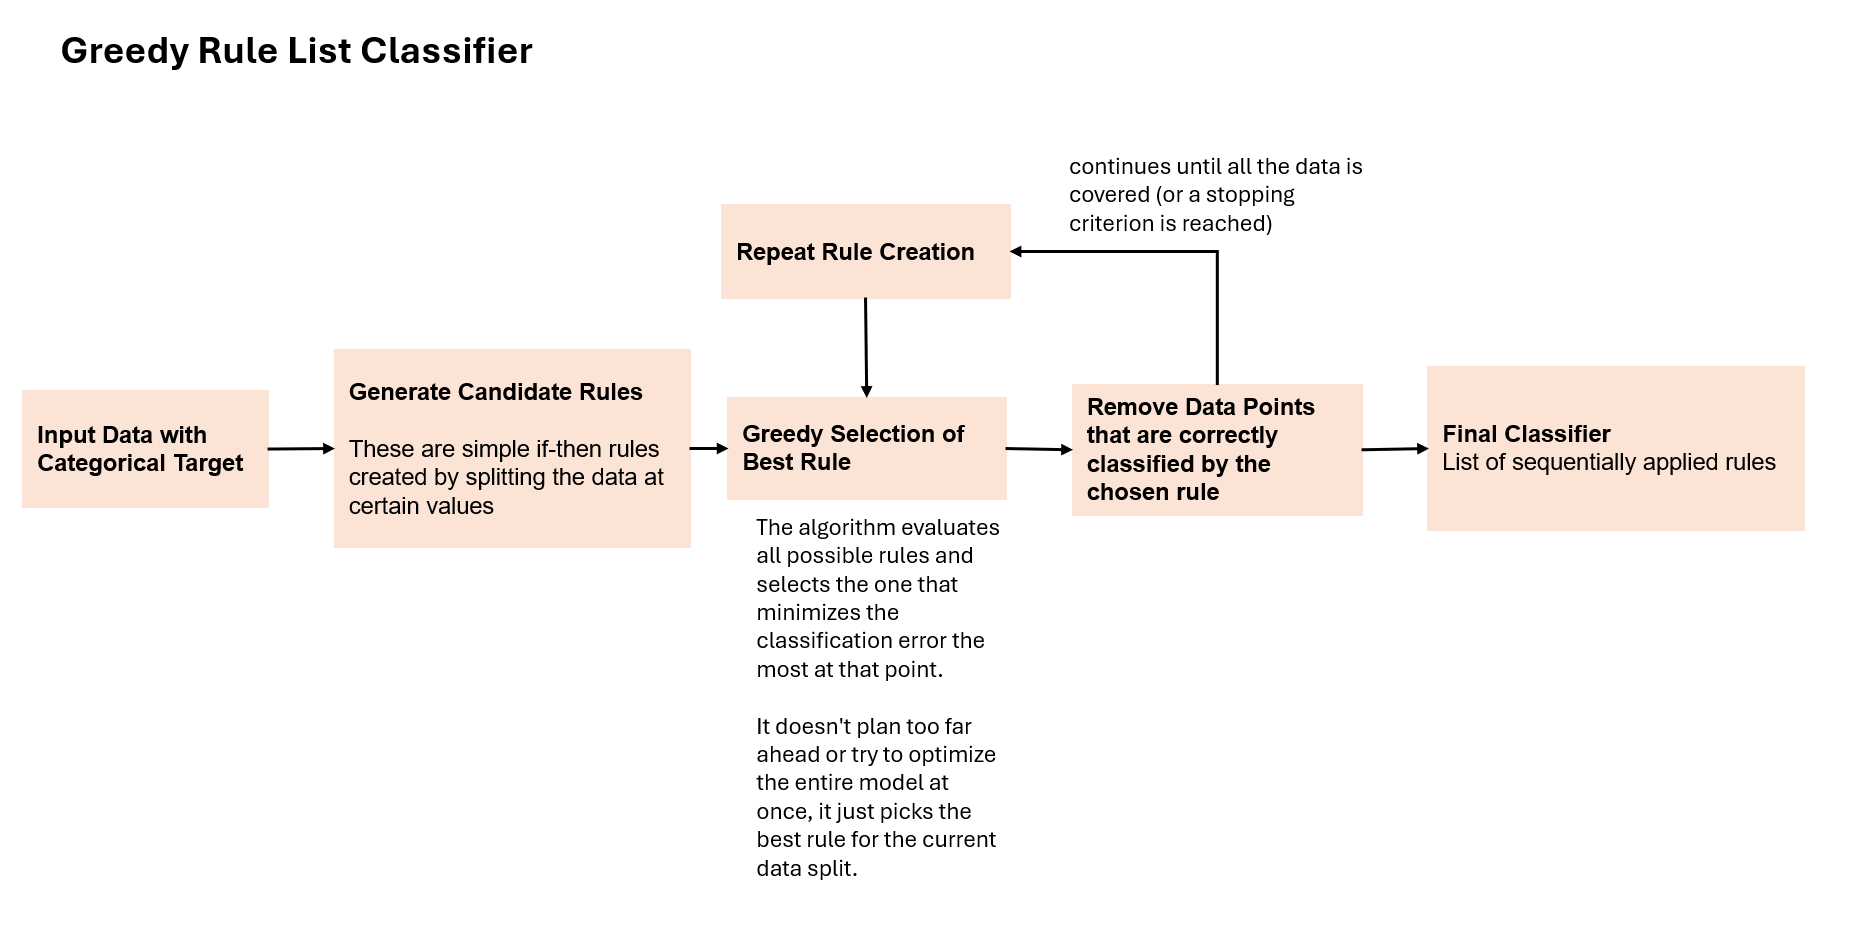

## Algorithm 3: Rule Fit Regressor

In [ ]:
rulefit = RuleFitRegressor(max_rules=10)
rulefit.fit(X_train_reg, y_train_reg, feature_names=X_train_reg.columns.tolist())

# get test performance
preds = rulefit.predict(X_test_reg)
print(f'Test R2: {metrics.r2_score(y_test_reg, preds):0.2f}')

rulefit

Test R2: 0.30


RuleFitRegressor(max_rules=10)

In [ ]:
rules = rulefit._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)

# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is the fraction of points it applies to
display(rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis'))

,rule,coef,support
9,Store <= 28.5,47338.369550,0.618104
11,Store <= 28.5 and CPI <= 213.4472,33637.231859,0.452603
8,Store > 28.5,-88936.114123,0.381896
10,Store <= 28.5 and CPI > 130.92794 and Unemployment > 6.844,19000.400156,0.361305
12,Store <= 28.5 and CPI <= 189.23104,110170.371635,0.325563
6,Store > 28.5 and CPI <= 135.04585,-43311.203601,0.133838
7,Store <= 10.0 and Store > 2.5 and CPI > 188.16277,-10140.702056,0.133256
13,Store <= 14.5 and CPI <= 189.29707 and Unemployment <= 9.982,373147.223465,0.081197
14,Store <= 14.5 and CPI <= 189.22186 and Unemployment <= 9.982,0.000000,0.081197


## Interpretation of the above table

The model explains that when the store size is less than or equal to 28.5, it significantly increases the predicted value by about 47,338.37. This rule applies to over 61% of the data. Conversely, if the store size is greater than 28.5, the prediction drops by about 88,936.11, which affects around 38% of the samples.


## Visual Explanation

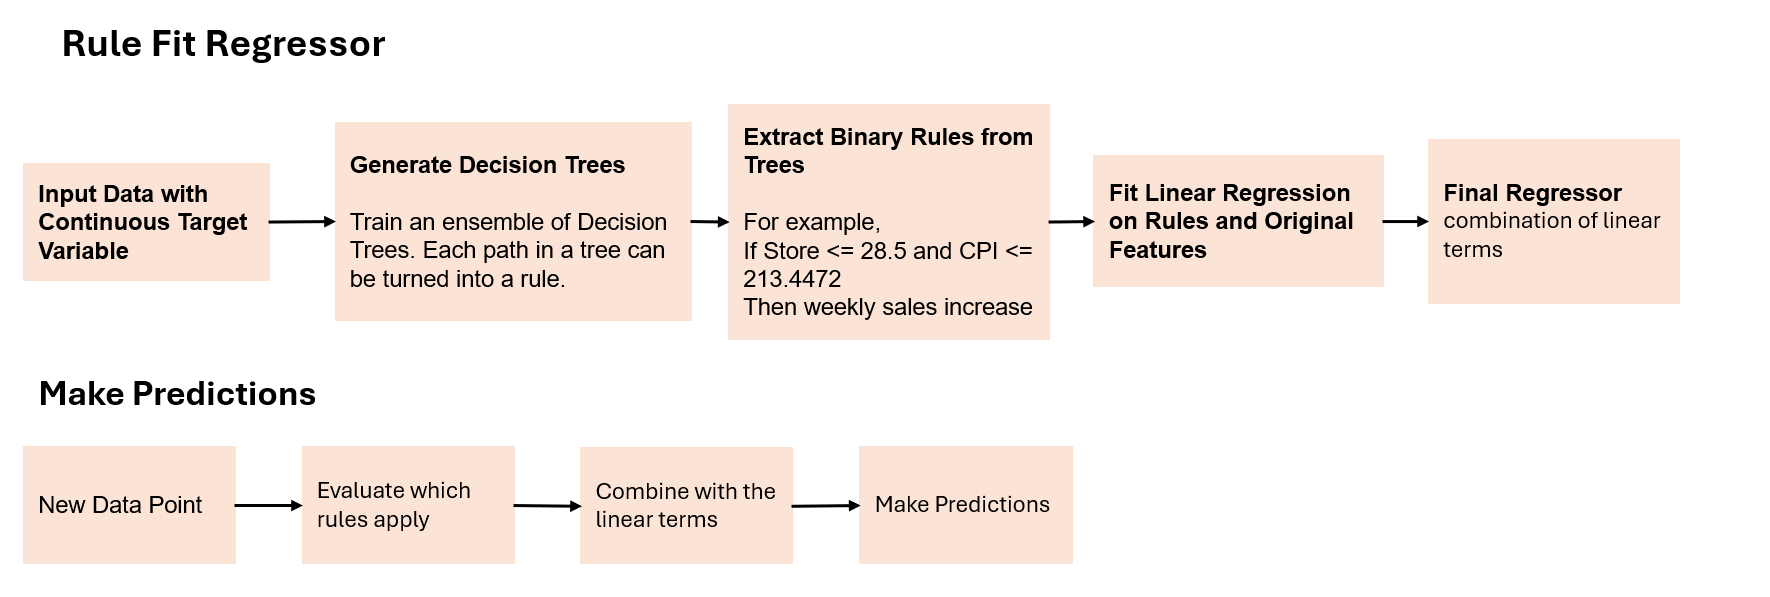